## Part I: Inventory & Capacity Planning
## Hyatt’s Problem (Overbooking level optimization)

,no_show,overbook_level,net_rooms,room_rev,denials,denial_cost,empty rooms,opportunity cost,profit
505,-1.0,14,100.0,15000.0,15.0,375.0,0.0,0.0,14625.0
1156,1.0,14,100.0,15000.0,13.0,325.0,0.0,0.0,14675.0
2531,1.0,14,100.0,15000.0,13.0,325.0,0.0,0.0,14675.0
3858,2.0,14,100.0,15000.0,12.0,300.0,0.0,0.0,14700.0
3414,2.0,14,100.0,15000.0,12.0,300.0,0.0,0.0,14700.0
...,...,...,...,...,...,...,...,...,...
2083,14.0,14,100.0,15000.0,0.0,0.0,0.0,0.0,15000.0
1441,14.0,14,100.0,15000.0,0.0,0.0,0.0,0.0,15000.0
3135,14.0,14,100.0,15000.0,0.0,0.0,0.0,0.0,15000.0
2841,14.0,14,100.0,15000.0,0.0,0.0,0.0,0.0,15000.0


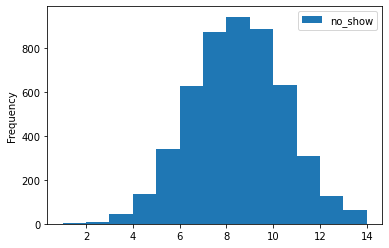

In [1]:
# input parameters
capacity = 100
room_price = 150
voucher = 25
no_show_mean = 8
no_show_sd = 2
simulation_run = 5000

# simulate the number of noshows
import pandas as pd
import numpy as np
df_no_show = pd.DataFrame({'no_show' : np.random.normal(no_show_mean,no_show_sd,simulation_run).round()})
df_no_show.plot.hist(bins=range(1, 15))

# as a rule of thumb, try the overbooking number between
# mean - 3SD, mean + 3SD
df_optimize = pd.DataFrame({'overbook_level' : np.arange(2,15)})

# use a loop to try different order levels and compute average profit
for i in np.arange(0,df_optimize.shape[0]):
    df_no_show['overbook_level'] = df_optimize.overbook_level[i]
    df_no_show['net_rooms'] = (capacity + df_optimize.overbook_level[i] - df_no_show.no_show).clip(upper=capacity)
    df_no_show['room_rev'] = df_no_show['net_rooms']*room_price
    df_no_show['denials'] = (df_optimize.overbook_level[i] - df_no_show.no_show).clip(lower=0)
    df_no_show['denial_cost'] = df_no_show['denials']*voucher
    # If calculated revenue at 100 capacity, instead of 'net_rooms', need to account separately for opportunity cost
    df_no_show['empty rooms'] = (df_no_show.no_show - df_optimize.overbook_level[i]).clip(lower=0)
    df_no_show['opportunity cost'] =  df_no_show['empty rooms']*room_price
    df_no_show['profit'] = df_no_show['room_rev'] - df_no_show['denial_cost'] - df_no_show['opportunity cost']
    df_optimize.loc[i,'avg_profit'] = df_no_show.profit.mean()
    df_optimize.loc[i,'sd_profit'] = df_no_show.profit.std()

# verify intermediate calculations done as expected     
df_no_show.sort_values('profit')   

In [2]:
# verify that avg_profit, sd_profit calculated and stored as expected
df_optimize.sort_values("avg_profit", ascending=False)

,overbook_level,avg_profit,sd_profit
9,11,14906.925,88.845360
8,10,14899.360,148.339109
10,12,14894.470,59.166031
11,13,14873.630,50.922900
7,9,14850.650,236.396921
12,14,14849.605,50.313768
6,8,14744.350,341.351918
5,7,14576.690,443.529861
4,6,14352.155,522.581907
3,5,14086.735,570.403135


[Text(0, 0.5, 'Expected Profit (avg_profit)'),
 Text(0.5, 0, 'Uncertainty (sd_profit)')]

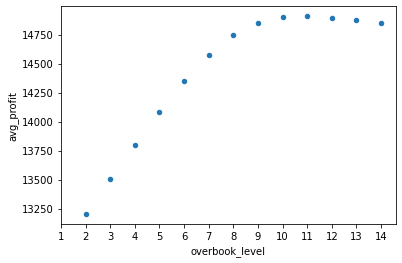

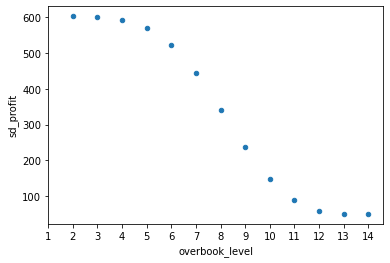

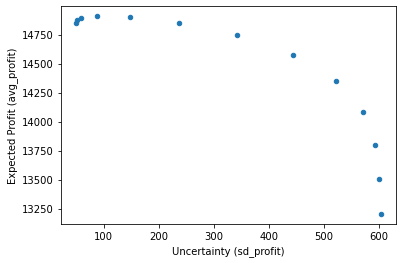

In [3]:
# relationship between avg and sd of profit with order level
df_optimize.plot.scatter(x='overbook_level',y='avg_profit',xticks=range(1, 15))
df_optimize.plot.scatter(x='overbook_level',y='sd_profit',xticks=range(1, 15))

# profit risk: efficiency frontier
df_optimize.plot.scatter(y='avg_profit',x='sd_profit').set(ylabel="Expected Profit (avg_profit)", xlabel="Uncertainty (sd_profit)")

### Answer: Overbooking level is 11, profit estimates is 14906.310 dollars.

## Part2 The Parka Problem (Inventory level optimization)

In [11]:
# set input parameters
demand_mean = 26
demand_sd = 3
simulation_run = 5000
Procurement_cost = 70
Original_price = 140
Markdown_price = 40

<AxesSubplot:ylabel='Frequency'>

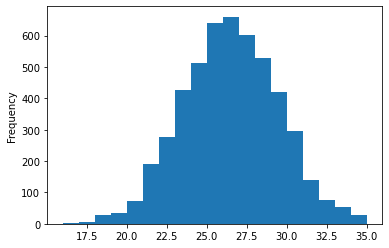

In [12]:
# numpy.random.seed(12345)
df_order = pd.DataFrame({'demand' : 
                           np.random.normal(demand_mean,demand_sd,
                                            simulation_run).round()})
df_order
#np.random.normal(10,5,50).std()
df_order.demand.plot.hist(bins=range(16,36))

In [13]:
# as a rule of thumb, try protection levels between
# mean - 3SD, mean + 3SD
# 26-3*3, 26+3*3
df_optimize1 = pd.DataFrame({'order_level' : np.arange(17,36)})

In [15]:
# use a loop to try different protection levels and compute average profit
for i in np.arange(0,df_optimize1.shape[0]):
    df_order['order_level'] = df_optimize1.order_level[i]
    df_order['original_sales'] = df_order.demand.clip(upper=df_optimize1.order_level[i])
    df_order['original_revenue'] = df_order.original_sales*Original_price
    df_order['left_sales'] = df_optimize1.order_level[i] - df_order.original_sales
    df_order['left_profit'] = df_order.left_sales*Markdown_price
    df_order['profit'] = df_order.original_revenue + df_order.left_profit - df_optimize1.order_level[i] * Procurement_cost
    df_optimize1.loc[i,'avg_profit'] =df_order.profit.mean()
    df_optimize1.loc[i,'sd_profit'] = df_order.profit.std()

In [16]:
df_optimize1.sort_values('avg_profit', ascending = False)

,order_level,avg_profit,sd_profit
11,28,1714.08,238.081268
10,27,1713.12,208.782623
12,29,1704.48,261.423790
9,26,1700.14,175.595408
13,30,1686.46,277.845475
8,25,1673.96,140.804416
14,31,1662.50,287.684380
15,32,1635.74,293.879440
7,24,1634.98,107.114398
16,33,1607.46,297.679813


<AxesSubplot:xlabel='order_level', ylabel='sd_profit'>

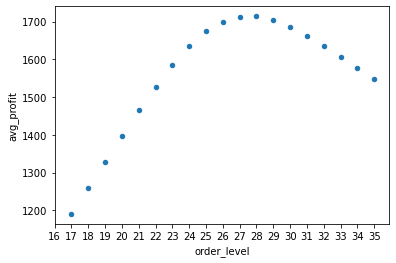

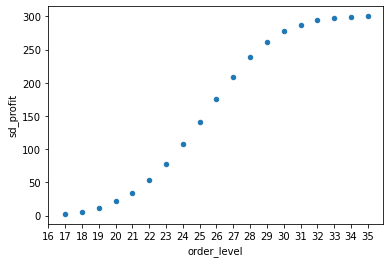

In [18]:
# relationship between avg and sd of profit with protection level
df_optimize1.plot.scatter(x='order_level',y='avg_profit',xticks=range(16,36))
df_optimize1.plot.scatter(x='order_level',y='sd_profit',xticks=range(16,36))

[Text(0, 0.5, 'Expected Profit (avg_profit)'),
 Text(0.5, 0, 'Uncertainty (sd_profit)')]

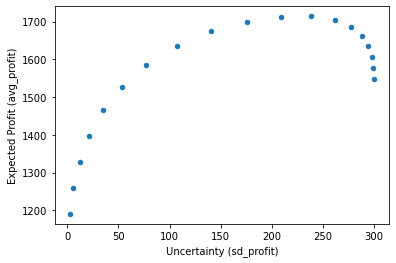

In [19]:
# profit risk: efficiency frontier
df_optimize1.plot.scatter(y='avg_profit',x='sd_profit').set(ylabel="Expected Profit (avg_profit)", xlabel="Uncertainty (sd_profit)")


### Answer: L.L. Bean should purchase 28 jackets from its supplier. Maximum expected profit is 1714.08.032.